# PA005: High Value Customer Identification(Insiders)

# <font color = 'red'> 0.0. Imports </font>

In [2]:
import os
import joblib
import re
import pickle
import s3fs
import sqlite3

import pandas as pd
import numpy as np
import seaborn as sns
import umap.umap_ as umap
import scipy.stats as st

from datetime import datetime
from matplotlib import pyplot as plt
from plotly import express as px
from sqlalchemy import create_engine

from sklearn import cluster as c
from sklearn import metrics as me
from sklearn import ensemble as en
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import manifold as mn
from sklearn import mixture as mx

In [42]:
AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID_INSIDERS')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY_INSIDERS')

## Load dataset

In [4]:
path_s3 = 's3://insiders-pgdm/data.csv'
path_local = '../data/raw/data.csv'

# load data
df_raw = pd.read_csv(path_local, encoding = 'ISO-8859-1')

# <font color = 'red'> 1.0. Data Description </font>

In [5]:
df1 = df_raw.copy()

In [6]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 1.1. Rename columns

In [7]:
cols_new = ['invoice_no', 'stock_code', 'description', 
            'quantity', 'invoice_date', 'unit_price', 
            'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [8]:
print('number of rows: {}'.format(df1.shape[0]))
print('number of columns: {}'.format(df1.shape[1]))

number of rows: 541909
number of columns: 8


## 1.3. Data types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [11]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [12]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge original df with reference df
df1 = pd.merge(df1, df_backup, on = 'invoice_no', how = 'left')

# coalesce -> combine_first()
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y'], axis = 1)

In [13]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [14]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%m/%d/%Y %H:%M').dt.date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

# customer id
df1['customer_id'] = df1['customer_id'].astype('int64')
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,United Kingdom,17850


In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive statistics

In [16]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [17]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - standard deviation, min, max, range, skew and kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.2. Categorical Attributes

#### Invoice No

In [18]:
# invoices with letters and numbers
# identification
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
df_letter_invoices.head()

print('Total number of invoices: {}'.format(len(df_letter_invoices)))
print('Total number of negative quantity: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock Code

In [19]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [20]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,United Kingdom,17850


#### Country

In [21]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [22]:
df1['country'].value_counts(normalize = True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [23]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# <font color = 'red'> 2.0. Data Filtering </font>

In [24]:
df2 = df1.copy()

In [25]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [26]:
# numerical attributes
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# categorical attributes
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis = 1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# <font color = 'red'> 3.0. Feature Engineering </font>

In [27]:
df3 = df2.copy()

## 3.1. Feature Creation

In [28]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 
                'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index = True)

In [29]:
df_ref.shape

(5786, 1)

### 3.1.1. Gross Revenue

In [30]:
# Gross Revenue quantity * price
df2_purchases = df2_purchases.copy()
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Days from Last Purchase

In [31]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left' )
df_ref.isna().sum()


customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Qty. Purchased

In [32]:
# Frequência de compra
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
        .groupby( 'customer_id' )
        .count()
        .reset_index()
        .rename(columns = {'invoice_no': 'qty_invoices'}))
df_ref = pd.merge(df_ref, df_freq, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
dtype: int64

### 3.1.4. Total Qty. Items Purchased

In [33]:
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum()
                                                        .reset_index()
                                                        .rename(columns={'quantity': 'qty_items'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_items        91
dtype: int64

### 3.1.5. Qty. of Products Purchased

In [34]:
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id' ).count()
                                                        .reset_index()
                                                        .rename(columns={'stock_code': 'qty_products'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_items        91
qty_products     91
dtype: int64

### 3.1.6. Average Ticket Value

In [35]:
# Average Ticket
df_avg_ticket = (df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id')
                .mean()
                .reset_index()
                .rename(columns = {'gross_revenue':'avg_ticket'}))
df_ref = pd.merge(df_ref, df_avg_ticket, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_items        91
qty_products     91
avg_ticket       91
dtype: int64

### 3.1.7. Average Recency Days

In [36]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending = [False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.8. Frequency Purchases

In [37]:
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby( 'customer_id')
                                                            .agg(max_ = ('invoice_date', 'max'), 
                                                                min_ = ('invoice_date', 'min'),
                                                                days_= ('invoice_date', lambda x: ((x.max() - x.min()).days ) + 1),
                                                                buy_ = ('invoice_no', 'count'))).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis = 1)

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.9. Number of Returns

In [38]:
# returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qty_returns'})
df_returns['qty_returns'] = df_returns['qty_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how = 'left', on = 'customer_id')
df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qty_returns            0
dtype: int64

# <font color = 'red'> 4.0. EDA (Exploratory Data Analysis) </font>

In [39]:
df4 = df_ref.dropna()

## 4.1. Estudo do Espaço

In [40]:
# df43 = df4.drop(columns = ['customer_id'], axis = 1).copy()
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 
                'qty_products', 'frequency', 'qty_returns']
df43 = df4[cols_selected].copy()

In [45]:
mm = pp.MinMaxScaler()

# AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID_INSIDERS')
# AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY_INSIDERS')

fs = s3fs.S3FileSystem(anon=False, key=AWS_ACCESS_KEY_ID, secret=AWS_SECRET_ACCESS_KEY)
df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
pickle.dump(mm, open('../src/features/gross_revenue_scaler.pkl', 'wb'))
# pickle.dump(mm, fs.open('s3://insiders-pgdm/gross_revenue_scaler.pkl', 'wb'))

df43['recency_days'] = mm.fit_transform(df43[['recency_days']])
pickle.dump(mm, open('../src/features/recency_days_scaler.pkl', 'wb'))
# pickle.dump(mm, fs.open('s3://insiders-pgdm/recency_days_scaler.pkl', 'wb'))

df43['qty_products'] = mm.fit_transform(df43[['qty_products']])
pickle.dump(mm, open('../src/features/qty_products_scaler.pkl', 'wb'))
# pickle.dump(mm, fs.open('s3://insiders-pgdm/qty_products_scaler.pkl', 'wb'))

df43['frequency'] = mm.fit_transform(df43[['frequency']])
pickle.dump(mm, open('../src/features/frequency_scaler.pkl', 'wb'))
# pickle.dump(mm, fs.open('s3://insiders-pgdm/frequency_scaler.pkl', 'wb'))

df43['qty_returns'] = mm.fit_transform(df43[['qty_returns']])
pickle.dump(mm, open('../src/features/qty_returns_scaler.pkl', 'wb'))
# pickle.dump(mm, fs.open('s3://insiders-pgdm/qty_returns_scaler.pkl', 'wb'))

X = df43.copy()

## 4.2. Tree-Based Embedding

In [47]:
# training dataset
X = df43.drop(columns = ['customer_id', 'gross_revenue'], axis = 1)
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators = 100, random_state = 42)

# model training
rf_model.fit(X, y)
pickle.dump(rf_model, open('../src/models/rf_model.pkl', 'wb'))
# pickle.dump(rf_model, fs.open('s3://insiders-pgdm/qty_returns_scaler.pkl', 'wb'))

# leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

In [48]:
# Dimensionality reducer
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_leaf)

pickle.dump(reducer, open('../src/features/umap_reducer.pkl', 'wb'))
# pickle.dump(reducer, fs.open('s3://insiders-pgdm/umap_reducer.pkl', 'wb'))


# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# <font color = 'red'> 5.0. Hyperparameter Fine-Tunning </font>

In [49]:
X = df_tree.copy()

In [50]:
X.head()

,embedding_x,embedding_y
0,10.918785,14.602229
1,19.531637,8.913908
2,11.945412,14.611155
3,0.142954,2.149642
4,-6.805303,9.022922


# <font color = 'red'> 6.0. Model Training </font>

## 6.1. Final Model

In [53]:
clusters = np.arange(2, 25, 1)

gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k, random_state=42)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = me.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

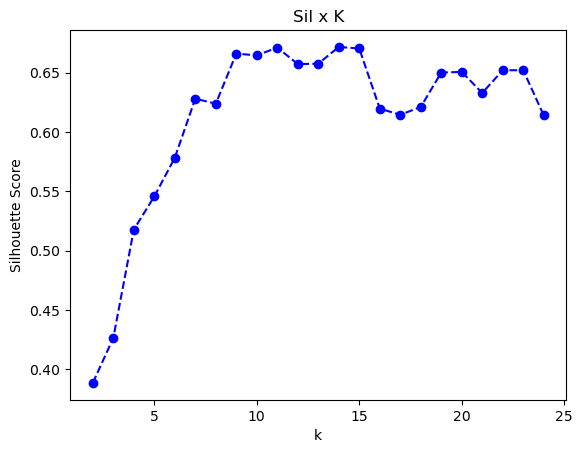

In [54]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('k');
plt.ylabel('Silhouette Score');
plt.title('Sil x K');

In [57]:
# model definition
k = 10

## model definition
gmm_model = mx.GaussianMixture(n_components = k, n_init = 300, random_state = 32)

# model training
gmm_model.fit(X)

# model predict
labels = gmm_model.predict(X)

## 6.2. Cluster Validation

In [58]:
# # WSS (Within-Cluster Sum of Square)
# print('WSS value: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS value: {}'.format(me.silhouette_score(X, labels, metric = 'euclidean')))

SS value: 0.6150678396224976


# <font color = 'red'> 7.0. Cluster Analysis </font>

In [59]:
df72 = df4[cols_selected].copy()
df72['cluster'] = labels

# change dtypes
df72['recency_days'] = df72['recency_days'].astype('int64')
df72['qty_products'] = df72['qty_products'].astype('int64')
df72['qty_returns'] = df72['qty_returns'].astype('int64')
df72['last_training_timestamp'] = datetime.now().strftime( '%Y-%m-%d %H:%M:%S')

In [60]:
df72.head()

,customer_id,gross_revenue,recency_days,qty_products,frequency,qty_returns,cluster,last_training_timestamp
0,17850,5391.21,372,297,17.000000,40,4,2023-04-12 14:41:42
1,13047,3232.59,56,171,0.028302,35,1,2023-04-12 14:41:42
2,12583,6705.38,2,232,0.040323,50,4,2023-04-12 14:41:42
3,13748,948.25,95,28,0.017921,0,0,2023-04-12 14:41:42
4,15100,876.00,333,3,0.073171,22,7,2023-04-12 14:41:42


In [61]:
# Number of customer
df_cluster = df72[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df72[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df72[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_qty_products = df72[['qty_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qty_products, how='inner', on='cluster')

# Frequency
df_frequency = df72[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# Returns
df_qty_returns = df72[['qty_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qty_returns, how='inner', on='cluster')

df_cluster.sort_values( 'gross_revenue', ascending=False )

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qty_products,frequency,qty_returns
4,4,373,12.567385,10503.060483,19.268097,475.581769,0.110615,187.120643
1,1,501,16.880054,2624.627305,40.948104,141.542914,0.047552,20.940120
9,9,95,3.200809,2291.266000,29.957895,222.136842,0.031576,0.663158
6,6,349,11.758760,2216.344413,69.501433,52.896848,0.072810,11.028653
5,5,404,13.611860,1689.182401,54.801980,89.202970,0.050037,11.542079
8,8,107,3.605121,1448.545701,65.364486,66.878505,0.066564,33.186916
2,2,372,12.533693,1237.753145,61.282258,54.357527,0.043705,8.771505
0,0,175,5.896226,827.478286,92.022857,26.822857,0.161952,22.868571
3,3,200,6.738544,647.933500,47.280000,11.510000,0.025991,0.845000
7,7,392,13.207547,505.728827,149.426020,15.522959,0.426596,9.443878


In [48]:
# ================ REPENSAR ESSAS CATEGORIAS ============== #
# 4 Cluster Insiders
# 1 Cluster More Products
# 9 Cluster Spend Money 
# 6 Cluster Even More Products
# 5 Cluster Less Days
# 8 Cluster Less 1k
# 2 Cluster Stop Returners
# 0 Cluster More Buy
# 3 Nenhum
# 7 Nenhum

# <font color = 'red'> 8.0. Deploy to Production </font>

In [99]:
df72.dtypes

customer_id                  int64
gross_revenue              float64
recency_days                 int64
qty_products                 int64
frequency                  float64
qty_returns                  int64
cluster                      int64
last_training_timestamp     object
dtype: object

## 8.1 Insert into SQLite

In [100]:
df72['recency_days'] = df72['recency_days'].astype('int64')
df72['qty_products'] = df72['qty_products'].astype('int64')
df72['qty_returns'] = df72['qty_returns'].astype('int64')

In [101]:
host = 'sqlite:///insiders_db.sqlite'
conn = create_engine(host)

In [102]:
# drop table
query_drop_insiders = """
    DROP TABLE insiders
"""


# create table
query_create_table_insiders = """
    CREATE TABLE insiders (
        customer_id INTEGER,
        gross_revenue REAL,
        recency_days INTEGER,
        qty_products INTEGER,
        frequency REAL,
        qty_returns REAL,
        cluster INTEGER,
        last_training_timestamp TIMESTAMP
    )
"""
conn = sqlite3.connect('insiders_db.sqlite')
conn.execute(query_drop_insiders)
conn.execute(query_create_table_insiders)
conn.commit()

# insert data into table
df72.to_sql('insiders', con = conn, if_exists = 'append', index = False)

2968

In [103]:
# select data
query = """
    SELECT * FROM insiders
"""
df = pd.read_sql_query(query, conn)

In [104]:
conn.close()

In [105]:
df.head()

,customer_id,gross_revenue,recency_days,qty_products,frequency,qty_returns,cluster,last_training_timestamp
0,17850,5391.21,372,297,17.000000,40.0,4,2023-04-12 14:41:42
1,13047,3232.59,56,171,0.028302,35.0,1,2023-04-12 14:41:42
2,12583,6705.38,2,232,0.040323,50.0,4,2023-04-12 14:41:42
3,13748,948.25,95,28,0.017921,0.0,0,2023-04-12 14:41:42
4,15100,876.00,333,3,0.073171,22.0,7,2023-04-12 14:41:42


In [106]:
df.shape

(2968, 8)